In [1]:
import cv2
from pathlib import Path
import numpy as np
# from PIL import Image
import torch
from torchvision.io.video import read_video
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights


In [2]:
source = Path('../DATASETS/VIRAT_subset_0102x')
videos = source.glob('*.mp4')
homography = list(source.glob('*img2world.txt'))[0]
H = np.loadtxt(homography, delimiter=',')



The homography matrix helps to transform points from image space to a flat world plane. The `README_homography.txt` from VIRAT describes:

> Roughly estimated 3-by-3 homographies are included for convenience. 
> Each homography H provides a mapping from image coordinate to scene-dependent world coordinate.
>   
> [xw,yw,zw]' = H*[xi,yi,1]'
> 
> xi: horizontal axis on image with left top corner as origin, increases right.
> yi: vertical axis on image with left top corner as origin, increases downward.
> 
> xw/zw: world x coordinate
> yw/zw: world y coordiante

In [3]:
# H.dot(np.array([20,300, 1]))

In [4]:
video_path = list(videos)[0]
video_path = Path("../DATASETS/VIRAT_subset_0102x/VIRAT_S_010200_00_000060_000218.mp4")

In [5]:
video_path

PosixPath('../DATASETS/VIRAT_subset_0102x/VIRAT_S_010200_00_000060_000218.mp4')

Suggestions from: https://stackabuse.com/retinanet-object-detection-with-pytorch-and-torchvision/

In [6]:
weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
model = retinanet_resnet50_fpn_v2(weights=weights, score_thresh=0.35)
# Put the model in inference mode
model.eval()
# Get the transforms for the model's weights
preprocess = weights.transforms()

In [7]:
# hub.set_dir()

In [8]:
video = cv2.VideoCapture(str(video_path))

> The score_thresh argument defines the threshold at which an object is detected as an object of a class. Intuitively, it's the confidence threshold, and we won't classify an object to belong to a class if the model is less than 35% confident that it belongs to a class.

The result from a single prediction coming from `model(batch)` looks like:

```python
{'boxes': tensor([[5.7001e+02, 2.5786e+02, 6.3138e+02, 3.6970e+02],
         [5.0109e+02, 2.4508e+02, 5.5308e+02, 3.4852e+02],
         [3.4096e+02, 2.7015e+02, 3.6156e+02, 3.1857e+02],
         [5.0219e-01, 3.7588e+02, 9.7911e+01, 7.2000e+02],
         [3.4096e+02, 2.7015e+02, 3.6156e+02, 3.1857e+02],
         [8.3241e+01, 5.8410e+02, 1.7502e+02, 7.1743e+02]]),
 'scores': tensor([0.8525, 0.6491, 0.5985, 0.4999, 0.3753, 0.3746]),
 'labels': tensor([64, 64,  1, 64, 18, 86])}
```

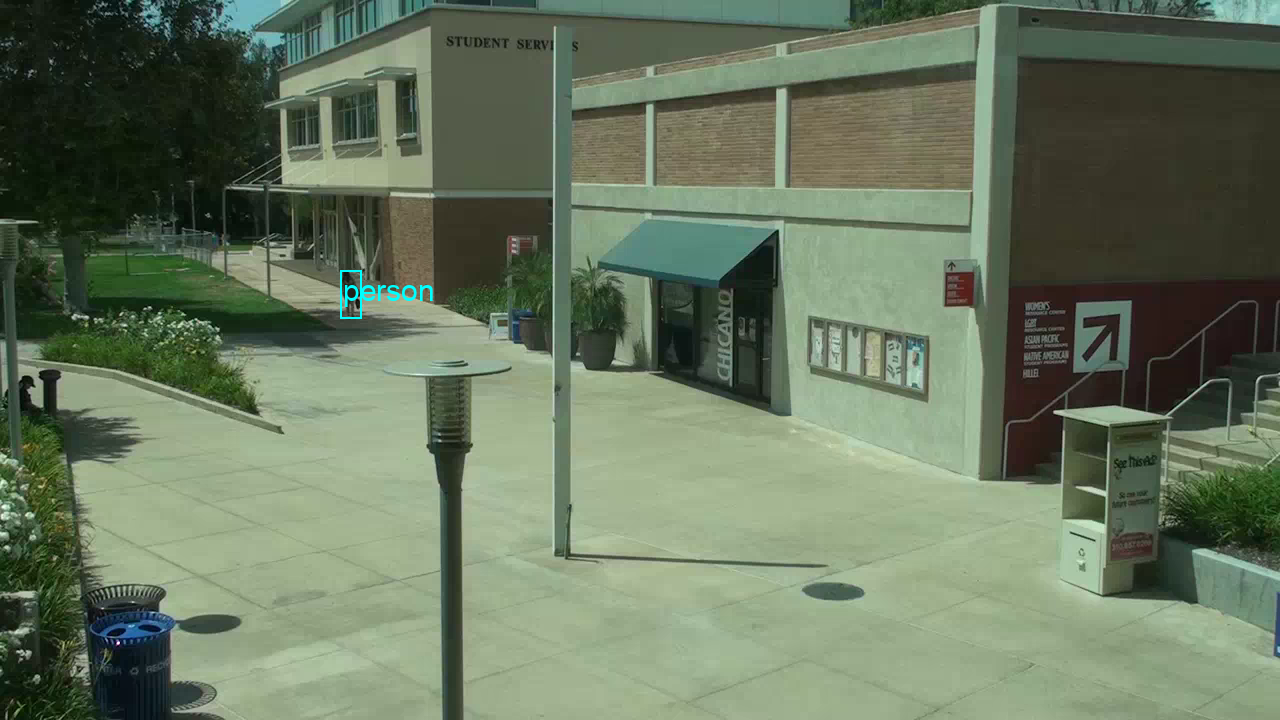

'frame 1'

{'boxes': tensor([[5.6998e+02, 2.5778e+02, 6.3132e+02, 3.6969e+02],
        [5.0109e+02, 2.4507e+02, 5.5308e+02, 3.4848e+02],
        [5.4706e-01, 3.7548e+02, 9.8450e+01, 7.2000e+02],
        [3.4061e+02, 2.7014e+02, 3.6137e+02, 3.1858e+02],
        [3.4061e+02, 2.7014e+02, 3.6137e+02, 3.1858e+02],
        [8.3206e+01, 5.8410e+02, 1.7512e+02, 7.1747e+02]]), 'scores': tensor([0.8500, 0.6467, 0.4990, 0.4889, 0.4773, 0.3656]), 'labels': tensor([64, 64, 64, 18,  1, 86])}


In [37]:
# TODO make into loop
%matplotlib inline


import pylab as pl
from IPython import display

i=0
while True:
    ret, frame = video.read()
    i+=1
    
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    t = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    t.shape
    # image = image[np.newaxis, :] 
    t = t.permute(2, 0, 1)
    t.shape

    batch = [preprocess(t)]
    # no_grad can be used on inference, should be slightly faster
    with torch.no_grad():
        predictions = model(batch)
    prediction = predictions[0] # we feed only one frame at the once

    mask = prediction['labels'] == 1 # if we want more than one: np.isin(prediction['labels'], [1,86])

    scores = prediction['scores'][mask]
    labels = prediction['labels'][mask]
    boxes = prediction['boxes'][mask]
    
    # TODO: introduce confidence and NMS supression: https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/PyTorch_Object_Tracking.ipynb
    # (which I _think_ we better do after filtering)
    # alternatively look at Soft-NMS https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c

    labels = [weights.meta["categories"][i] for i in labels]

    box = draw_bounding_boxes(t, boxes=boxes,
                            labels=labels,
                            colors="cyan",
                            width=2, 
                            font_size=30,
                            font='Arial')

    im = to_pil_image(box.detach())

    display.display(im, f"frame {i}")
    print(prediction)
    display.clear_output(wait=True)

    break # for now
    # pl.clf()
    # # pl.plot(pl.randn(100))
    # pl.figure(figsize=(24,50))
    # # fig.axes[0].imshow(img)
    # pl.imshow(im)
    # display.display(pl.gcf(), f"frame {i}")
    # display.clear_output(wait=True)
    # time.sleep(1.0)

    # fig, ax = plt.subplots(figsize=(16, 12))
    # ax.imshow(im)
    # plt.show()



In [36]:
prediction

{'boxes': tensor([[5.7001e+02, 2.5786e+02, 6.3138e+02, 3.6970e+02],
         [5.0109e+02, 2.4508e+02, 5.5308e+02, 3.4852e+02],
         [3.4096e+02, 2.7015e+02, 3.6156e+02, 3.1857e+02],
         [5.0219e-01, 3.7588e+02, 9.7911e+01, 7.2000e+02],
         [3.4096e+02, 2.7015e+02, 3.6156e+02, 3.1857e+02],
         [8.3241e+01, 5.8410e+02, 1.7502e+02, 7.1743e+02]]),
 'scores': tensor([0.8525, 0.6491, 0.5985, 0.4999, 0.3753, 0.3746]),
 'labels': tensor([64, 64,  1, 64, 18, 86])}

In [21]:
prediction['labels'] == 1

tensor([False, False,  True, False, False, False])

In [23]:
prediction['boxes'][prediction['labels'] == 1]
prediction['scores'][prediction['labels'] == 1]

tensor([0.5985])